In [2]:
!git clone https://github.com/cesarlegendre/credit_scoring_7904_Q4_2024

Cloning into 'credit_scoring_7904_Q4_2024'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 14), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 63.60 KiB | 2.36 MiB/s, done.
Resolving deltas: 100% (14/14), done.


# Health insurance cost

### Introduction

This notebook aims to predict individual medical costs billed by health insurance based on several factors using **Linear Regression** and **Random Forest Regression**. We will perform an exploratory data analysis (EDA), create predictive models, and evaluate their performance using Root Mean Squared Error (RMSE) and Normalized RMSE (NRMSE).


In [15]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

file = 'credit_scoring_7904_Q4_2024/data_sets/health_cost/insurance.csv'


## Step 2: Loading the Data
We load the dataset which contains information about age, sex, BMI, smoking habits, number of children, region, and medical charges.

In [17]:
# Load data
data = pd.read_csv(file)
data.sample(4)


,age,sex,bmi,children,smoker,region,charges
909,32,female,24.600,0,yes,southwest,17496.30600
134,20,female,28.785,0,no,northeast,2457.21115
1134,28,male,33.820,0,no,northwest,19673.33573
1135,50,female,28.120,3,no,northwest,11085.58680


## Step 3: Understanding the Data

##Column Descriptions:

* **age**: Age of the primary beneficiary.
* **sex**: Gender of the beneficiary.
* **bmi**: Body Mass Index, a measure of body fat based on height and weight.
* **children**: Number of dependents.
* **smoker**: Whether the beneficiary is a smoker.
* **region**: Region in the US where the beneficiary resides.
* **charges**: Medical costs billed by the * health insurance (target variable).

We inspect the structure of the dataset and calculate basic statistics.

In [18]:
print(data.info())

# Summarize the dataset
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max

## Step 4: Exploratory Data Analysis (EDA)

We'll start by visualizing relationships between some of the variables.

### Pairplot of Features

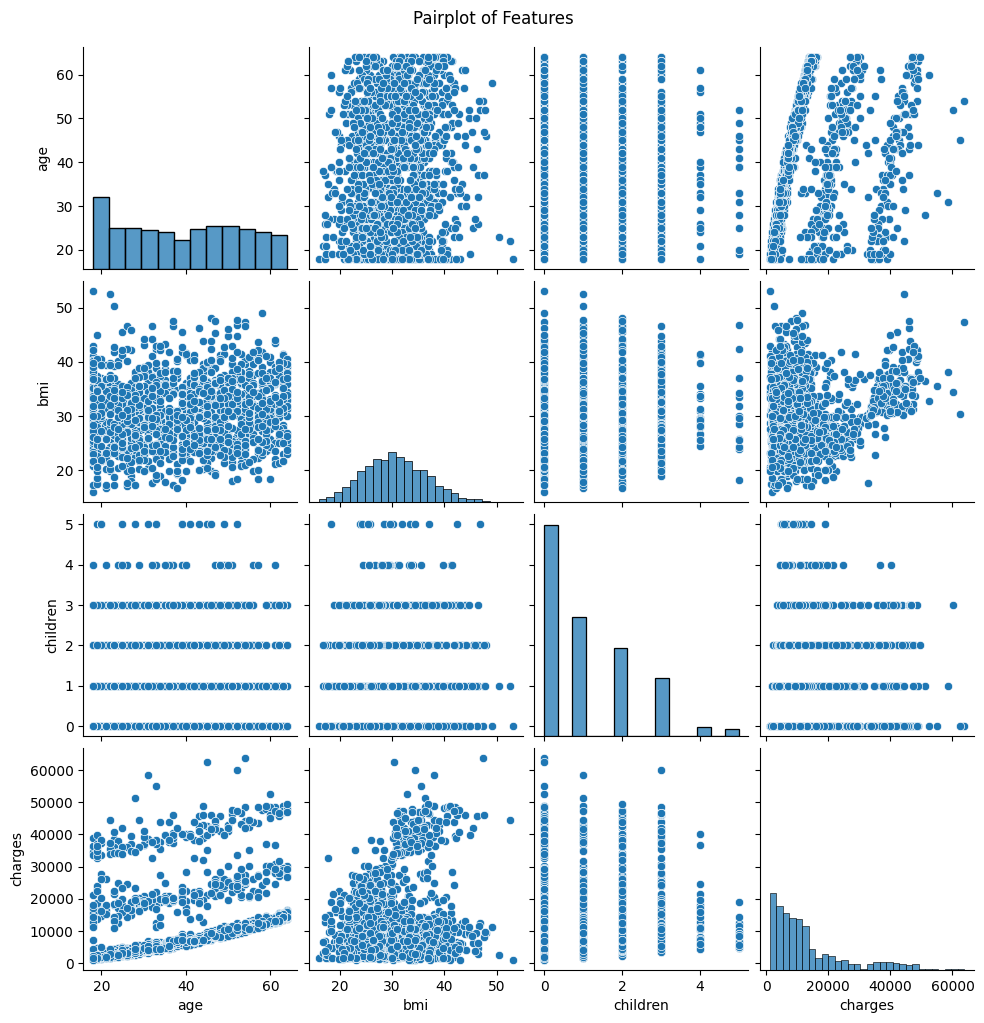

In [19]:
sns.pairplot(data)
plt.suptitle("Pairplot of Features", y=1.02)
plt.show()


### Correlation Analysis
We'll compute and visualize the correlation between age, bmi, and charges to understand how these features are related.

              age       bmi   charges
age      1.000000  0.109272  0.299008
bmi      0.109272  1.000000  0.198341
charges  0.299008  0.198341  1.000000


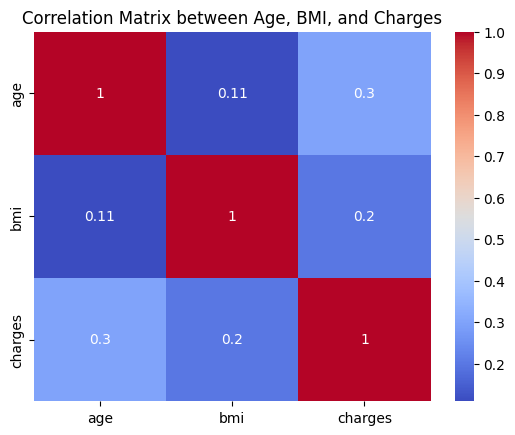

In [20]:
# Compute the correlation matrix
cor_matrix = data[['age', 'bmi', 'charges']].corr()
print(cor_matrix)

# Visualize the correlation matrix
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix between Age, BMI, and Charges")
plt.show()

## Step 5: Visualizing Relationships between Variables

### Scatterplots
**1. Age vs. Charges and BMI vs. Charges**

We'll plot scatter plots to observe the relationships between age and bmi with medical charges.

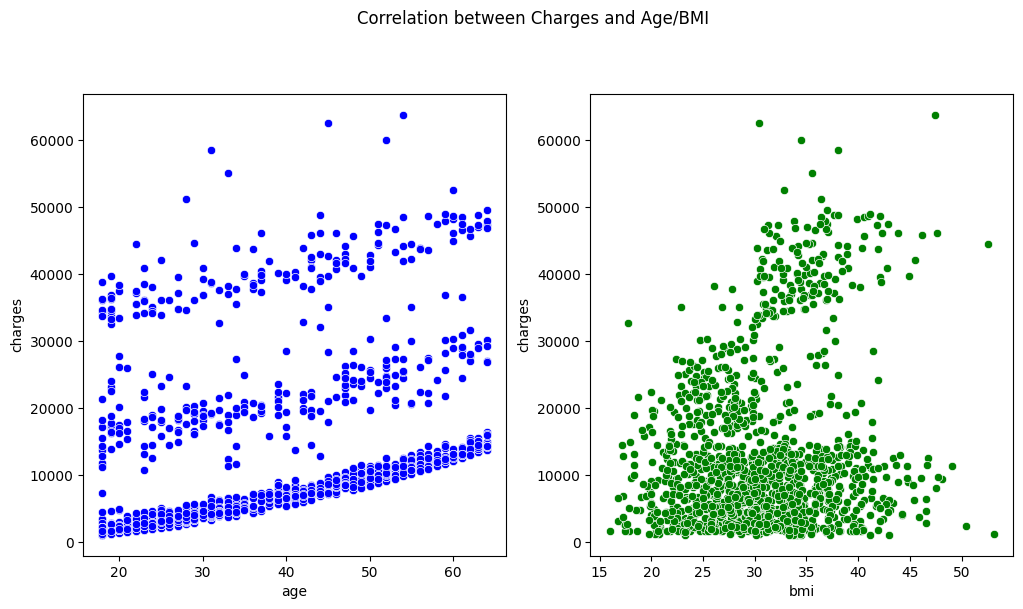

In [21]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.scatterplot(data=data, x='age', y='charges', ax=axes[0], color="blue")
sns.scatterplot(data=data, x='bmi', y='charges', ax=axes[1], color="green")
plt.suptitle("Correlation between Charges and Age/BMI", y=1.02)
plt.show()

**2. Sex vs. Charges and Children vs. Charges**

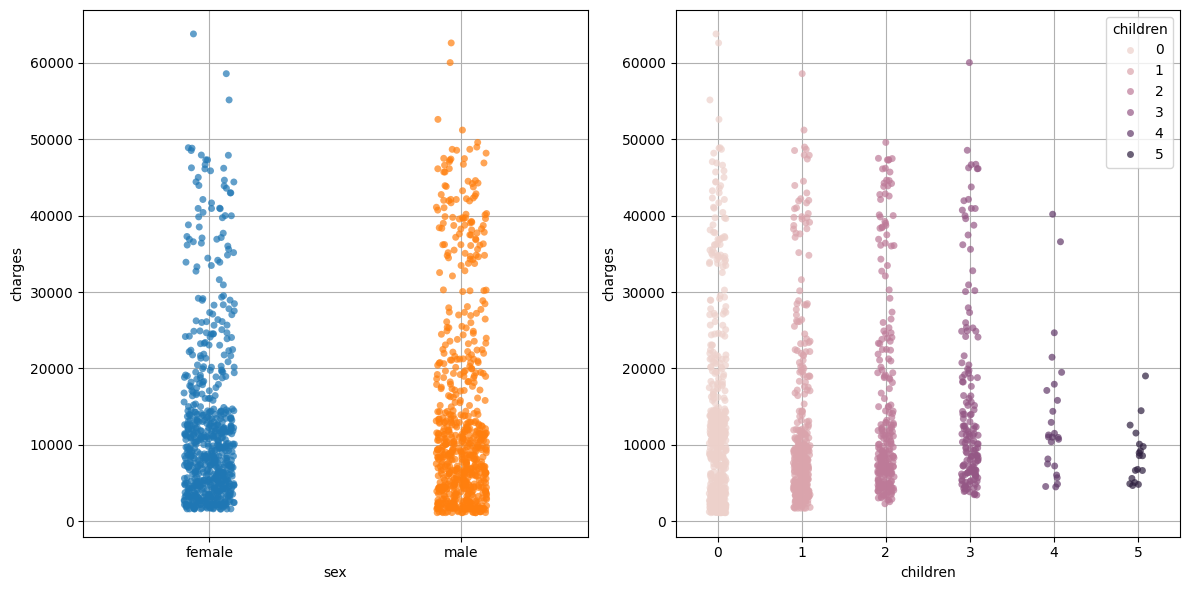

In [28]:
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot sex vs. charges with jitter
sns.stripplot(data=data, x='sex', y='charges', hue='sex', jitter=True, alpha=0.7, ax=axes[0])

# Plot children vs. charges with jitter
sns.stripplot(data=data, x='children', y='charges', hue='children', jitter=True, alpha=0.7, ax=axes[1])

# Apply consistent theme
for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()


**3. Smoker vs. Charges and Region vs. Charges**

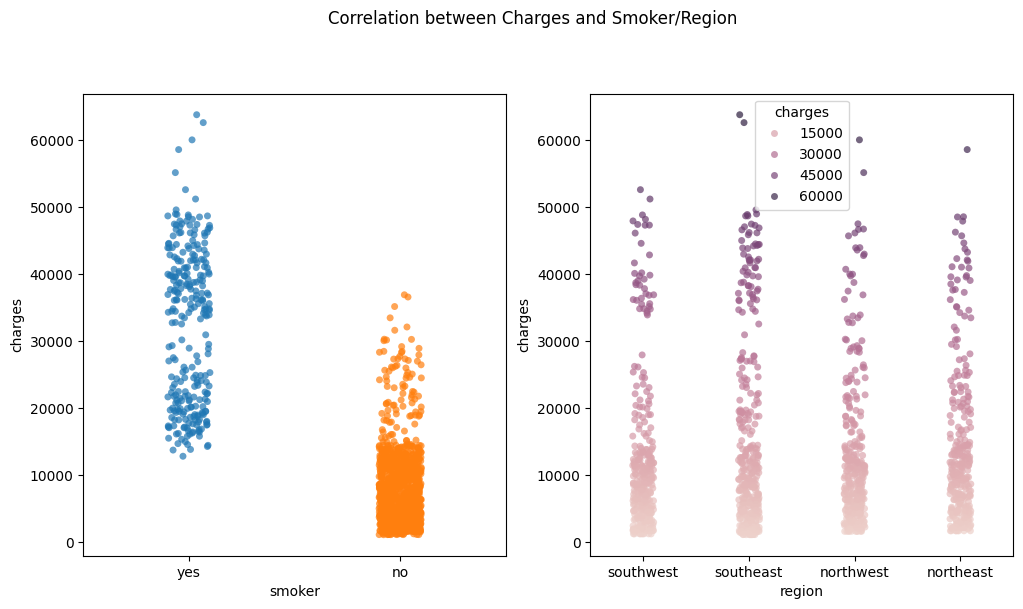

In [32]:
# Further analysis with smoker and region
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.stripplot(data=data, x='smoker', y='charges', hue='smoker', jitter=True, alpha=0.7, ax=axes[0])
sns.stripplot(data=data, x='region', y='charges', hue='charges', jitter=True, alpha=0.7, ax=axes[1])

plt.suptitle("Correlation between Charges and Smoker/Region", y=1.02)
plt.show()


## Step 6: Model Building
We will now build two predictive models: a Linear Regression model and a Random Forest model. We'll split the data into training and testing sets and evaluate the models using RMSE and NRMSE.

### Train/Test Split
We will use an 80/20 split, where 80% of the data will be used for training and 20% for testing.

In [33]:
# Splitting the data
X = pd.get_dummies(data.drop(columns='charges'), drop_first=True)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=406)


### 6.1 Linear Regression Model
We'll build and evaluate a linear regression model.

In [34]:
# Linear Regression Model

# y = x_1*c_1 + x_2*c_2 + ... + x_n*c_n + c_0
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Displaying model coefficients
print("Intercept:", linear_model.intercept_) # print constant C
print(pd.DataFrame({'Feature': X_train.columns, 'Coefficient': linear_model.coef_}))


Intercept: -12712.222729157567
            Feature   Coefficient
0               age    261.030962
1               bmi    368.167862
2          children    378.561155
3          sex_male     28.228366
4        smoker_yes  23669.626250
5  region_northwest   -542.898467
6  region_southeast  -1320.722082
7  region_southwest  -1076.227722


### Evaluating the Linear Regression Model
We calculate the RMSE and NRMSE on the test data to measure the accuracy of the model.

In [36]:
# Predictions
y_pred = linear_model.predict(X_test)

# Evaluate the Linear Regression Model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
nrmse = rmse / np.mean(y_test) * 100
print("Root Mean Squared Error on Test Data:", rmse)
print("Normalized RMSE (percentage):", nrmse, "%")


Root Mean Squared Error on Test Data: 5403.844725434219
Normalized RMSE (percentage): 45.089538715349974 %


### 6.2 Random Forest Model

Next, we'll train a **Random Forest** model and evaluate its performance.

In [39]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=500, max_features=3, random_state=406)
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_features=3, n_estimators=500, random_state=406)

In [40]:
# Predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate RMSE and NRMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
nrmse_rf = rmse_rf / np.mean(y_test) * 100
print("Root Mean Squared Error on Test Data (RF):", rmse_rf)
print("Normalized RMSE (percentage):", nrmse_rf, "%")


Root Mean Squared Error on Test Data (RF): 4266.317514650655
Normalized RMSE (percentage): 35.5980414913493 %


### Feature Importance in Random Forest
We can examine which features the Random Forest model considers most important for predicting charges.

In [41]:
# Feature Importance
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_model.feature_importances_}).sort_values(by='Importance', ascending=False)
print(importances)

            Feature  Importance
4        smoker_yes    0.602217
1               bmi    0.186175
0               age    0.152614
2          children    0.026101
3          sex_male    0.009921
6  region_southeast    0.008778
5  region_northwest    0.007341
7  region_southwest    0.006854


## Step 7: Residual Analysis

###Linear Model Residuals

We'll analyze the residuals (the difference between the predicted and actual values) to see how well the linear model performs.

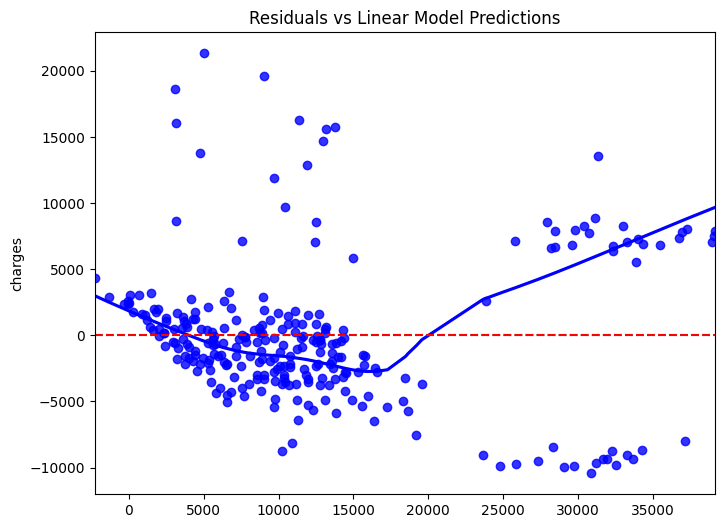

In [42]:
# Residual plot for Linear Regression
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Linear Model Predictions")
plt.show()

# This fits a Lowess (Locally Weighted Scatterplot Smoothing) curve, which helps visualize any patterns in the residuals.


### Random Forest Residuals
We repeat the same residual analysis for the Random Forest model.

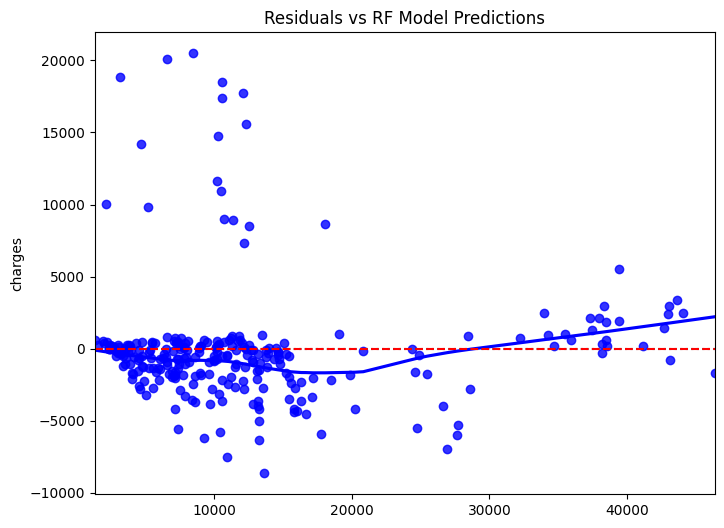

In [44]:
# Residual plot for Random Forest
residuals_rf = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred_rf, y=residuals_rf, lowess=True, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs RF Model Predictions")
plt.show()


# Conclusion
This notebook demonstrates how Linear Regression and Random Forest models can be applied to predict health care costs based on a set of features. Random Forest outperforms the Linear Regression model in terms of accuracy (lower RMSE and NRMSE), likely due to its ability to capture non-linear relationships and interactions between variables.